In [1]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.models import inception_v3
import torchvision.transforms as T

import matplotlib.pyplot as plt
import torchvision.utils as vutils
import imageio

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.linalg import sqrtm
import lpips

import warnings
warnings.filterwarnings("ignore")

In [3]:
celeba_dir = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'   

In [4]:
class SketchPhotoDataset(Dataset):
    def __init__(self, image_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)[:5000]
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_names)

    def convert_to_sketch(self,image):
        # Step 1: Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        # Step 2: Invert the grayscale image
        inverted = 255 - gray
    
        # Step 3: Apply Gaussian blur to the inverted image
        blur = cv2.GaussianBlur(inverted, (21, 21), sigmaX=0, sigmaY=0)
    
        # Step 4: Dodge blend
        dodge = cv2.divide(gray, 255 - blur, scale=256)
    
        # Step 5: Apply Laplacian edge detection for enhancement
        edges = cv2.Laplacian(gray, cv2.CV_8U, ksize=5)
        edges = cv2.GaussianBlur(edges, (3, 3), 0)
    
        # Step 6: Blend sketch and edges
        sketch = cv2.subtract(dodge, edges // 3)
        sketch = np.clip(sketch, 0, 255).astype(np.uint8)

        # Step 6: Reduce noise while preserving pencil strokes using fastNlMeansDenoising.
        # h: Filter strength, templateWindowSize: size in pixels, searchWindowSize: size in pixels for neighborhood search.
        sketch = cv2.fastNlMeansDenoising(sketch, h=15, templateWindowSize=7, searchWindowSize=21)
        
        return sketch

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
    
        if image is None:
            raise ValueError(f"Image not found: {img_path}")
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_size)
    
        sketch = self.convert_to_sketch(image)
        sketch = cv2.resize(sketch, self.image_size)
    
        # Convert single-channel sketch to 3-channel
        sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2RGB)
    
        if self.transform:
            image = self.transform(image)                      # RGB image
            sketch = self.transform(sketch)                    # Now also RGB
        else:
            image = transforms.ToTensor()(image)
            sketch = transforms.ToTensor()(sketch)
    
        return sketch, image


In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1] for GANs
])

# Define your dataset
dataset = SketchPhotoDataset(celeba_dir, transform=transform)

# Calculate lengths for train and validation sets
total_size = len(dataset)
val_size = int(0.1 * total_size)
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

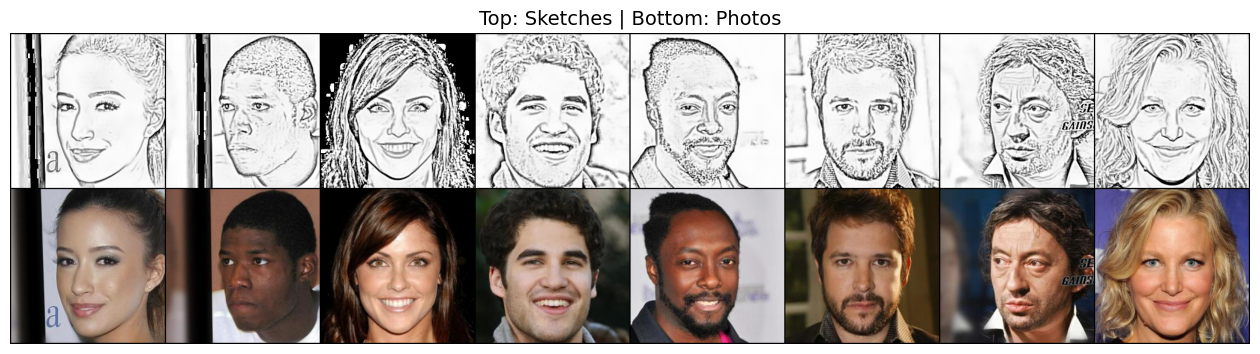

In [6]:
# Get a batch
sketches, photos = next(iter(train_loader))
sketches, photos = sketches[:8], photos[:8]  # Select first 8 pairs

# Denormalize
def denormalize(tensor):
    return tensor * 0.5 + 0.5

sketches = denormalize(sketches)  # (8, 1, H, W)
photos = denormalize(photos)      # (8, 3, H, W)

# Stack them as [sk1, sk2, ..., sk8, img1, img2, ..., img8]
grid = torch.cat([sketches, photos], dim=0)  # (16, 3, H, W)
grid = vutils.make_grid(grid, nrow=8, padding=2)

# Plot
plt.figure(figsize=(16, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Top: Sketches | Bottom: Photos", fontsize=14)
plt.axis('off')
plt.show()


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_sketch2image(generator, discriminator, dataloader):
    generator.eval()
    discriminator.eval()

    lpips_model = lpips.LPIPS(net='alex').to(device)
    resize = T.Resize((299, 299))
    normalize = T.Normalize([0.5]*3, [0.5]*3)

    psnr_list, ssim_list, lpips_list, disc_conf_list = [], [], [], []
    real_feats, fake_feats = [], []

    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.fc = torch.nn.Identity()
    inception.eval()

    with torch.no_grad():
        for sketch, real in tqdm(dataloader, desc="Evaluating"):
            sketch = sketch.to(device)   # [B, 1, H, W]
            real = real.to(device)       # [B, 3, H, W]

            fake = generator(sketch)     # [B, 3, H, W]

            # LPIPS, PSNR, SSIM
            for i in range(fake.size(0)):
                real_i = real[i].cpu().numpy().transpose(1, 2, 0)
                fake_i = fake[i].cpu().numpy().transpose(1, 2, 0)

                real_i = np.clip(real_i, 0, 1)
                fake_i = np.clip(fake_i, 0, 1)

                psnr_list.append(psnr(real_i, fake_i, data_range=1.0))
                ssim_list.append(ssim(real_i, fake_i, data_range=1.0, win_size=3, channel_axis=-1))
                lpips_list.append(lpips_model(fake[i:i+1], real[i:i+1]).item())

            # PatchGAN Discriminator confidence
            disc_conf_list.append(discriminator(sketch, fake).mean().item())

            # Resize for Inception (for FID)
            real_resized = resize(real)
            fake_resized = resize(fake)

            real_feats.append(inception(normalize(real_resized)).cpu().numpy())
            fake_feats.append(inception(normalize(fake_resized)).cpu().numpy())

    # FID Calculation
    real_feats = np.concatenate(real_feats, axis=0)
    fake_feats = np.concatenate(fake_feats, axis=0)
    mu1, sigma1 = real_feats.mean(0), np.cov(real_feats, rowvar=False)
    mu2, sigma2 = fake_feats.mean(0), np.cov(fake_feats, rowvar=False)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2 * covmean)

    # Print clean summary
    print("\n📊 Evaluation Results")
    print(f"🔹 PSNR:               {np.mean(psnr_list):.2f}")
    print(f"🔹 SSIM:               {np.mean(ssim_list):.4f}")
    print(f"🔹 LPIPS:              {np.mean(lpips_list):.4f}")
    print(f"🔹 FID:                {fid:.2f}")
    print(f"🔹 Disc Confidence:    {np.mean(disc_conf_list):.4f}")

    return {
        "PSNR": np.mean(psnr_list),
        "SSIM": np.mean(ssim_list),
        "LPIPS": np.mean(lpips_list),
        "FID": fid,
        "Disc_Confidence": np.mean(disc_conf_list)
    }

In [8]:
def setup_fixed_batch(loader, device, num_samples=5):
    """Call once before training to fix a sketch-photo batch for visualization."""
    sketches, photos = next(iter(loader))
    return sketches[:num_samples].to(device), photos[:num_samples].to(device)

def denormalize(tensor):
    """Convert from [-1, 1] to [0, 1] range for visualization."""
    return tensor * 0.5 + 0.5

def save_epoch_samples(G, sketches_fixed, epoch, save_dir="training_progress"):
    """Saves side-by-side sketch → fake image results for a fixed batch."""
    os.makedirs(save_dir, exist_ok=True)
    G.eval()

    with torch.no_grad():
        fakes = G(sketches_fixed.to(next(G.parameters()).device))


    # Denormalize both sketches and fakes
    sketches_fixed = denormalize(sketches_fixed.cpu())
    fakes = denormalize(fakes.cpu())

    # Concatenate: first row = sketch, second row = generated photo
    grid = torch.cat([sketches_fixed, fakes], dim=0)
    grid = vutils.make_grid(grid, nrow=sketches_fixed.size(0), padding=2)

    save_path = os.path.join(save_dir, f"epoch_{epoch:03d}.png")
    save_image(grid, save_path)

    G.train()



In [9]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.block(x)
        return self.dropout(x) if self.use_dropout else x


class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        # Encoder
        self.down1 = UNetBlock(in_channels, 64, down=True, use_dropout=False)
        self.down2 = UNetBlock(64, 128)
        self.down3 = UNetBlock(128, 256)
        self.down4 = UNetBlock(256, 512)
        self.down5 = UNetBlock(512, 512)
        self.down6 = UNetBlock(512, 512)
        self.down7 = UNetBlock(512, 512)
        self.down8 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU()
        )

        # Decoder
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False)
        self.up5 = UNetBlock(1024, 256, down=False)
        self.up6 = UNetBlock(512, 128, down=False)
        self.up7 = UNetBlock(256, 64, down=False)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        bottleneck = self.down8(d7)

        # Decoder with skip connections
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        out = self.final(torch.cat([u7, d1], dim=1))
        return out
    

In [10]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=6):
        super().__init__()
        def block(in_c, out_c, stride=2):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, stride, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            block(in_channels, 64),
            block(64, 128),
            block(128, 256),
            block(256, 512, stride=1),
            nn.Conv2d(512, 1, 4, 1, 1)  # Output: Patch matrix
        )

    def forward(self, x, y):
        # Concatenate sketch and photo: (B, 1+3, H, W)
        input = torch.cat([x, y], dim=1)
        return self.model(input)

In [11]:
# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 2e-4
LAMBDA_L1 = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_SAMPLE_EVERY = 5

fixed_sketches, fixed_photos = setup_fixed_batch(val_loader, DEVICE, num_samples=5)
eval_history = []

In [12]:
G = UNetGenerator().to(DEVICE)
D = PatchDiscriminator().to(DEVICE)

bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=60, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.5)


Training: 100%|██████████| 282/282 [06:38<00:00,  1.41s/it]


Epoch [1/50]  D Loss: 0.2281  G Loss: 28.8917


Training: 100%|██████████| 282/282 [06:14<00:00,  1.33s/it]


Epoch [2/50]  D Loss: 0.0171  G Loss: 36.5634


Training: 100%|██████████| 282/282 [06:14<00:00,  1.33s/it]


Epoch [3/50]  D Loss: 0.0244  G Loss: 23.9391


Training: 100%|██████████| 282/282 [06:14<00:00,  1.33s/it]


Epoch [4/50]  D Loss: 0.1852  G Loss: 23.3874


Training: 100%|██████████| 282/282 [06:14<00:00,  1.33s/it]


Epoch [5/50]  D Loss: 0.1495  G Loss: 29.8750
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 228MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 199MB/s] 
Evaluating: 100%|██████████| 32/32 [00:55<00:00,  1.75s/it]



📊 Evaluation Results
🔹 PSNR:               10.50
🔹 SSIM:               0.5032
🔹 LPIPS:              0.2808
🔹 FID:                116.87
🔹 Disc Confidence:    -1.1594


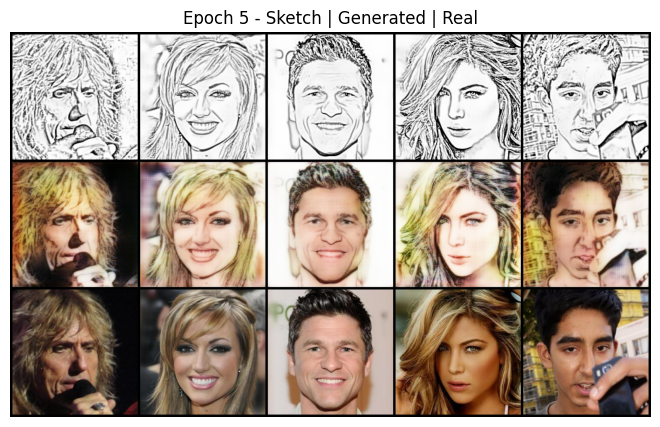

Training: 100%|██████████| 282/282 [06:14<00:00,  1.33s/it]


Epoch [6/50]  D Loss: 0.8201  G Loss: 20.3191


Training: 100%|██████████| 282/282 [06:15<00:00,  1.33s/it]


Epoch [7/50]  D Loss: 0.0029  G Loss: 24.3208


Training: 100%|██████████| 282/282 [06:14<00:00,  1.33s/it]


Epoch [8/50]  D Loss: 0.1423  G Loss: 25.2612


Training: 100%|██████████| 282/282 [06:16<00:00,  1.34s/it]


Epoch [9/50]  D Loss: 1.1993  G Loss: 21.8597


Training: 100%|██████████| 282/282 [06:17<00:00,  1.34s/it]


Epoch [10/50]  D Loss: 0.0263  G Loss: 24.3636
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:53<00:00,  1.68s/it]



📊 Evaluation Results
🔹 PSNR:               14.40
🔹 SSIM:               0.6411
🔹 LPIPS:              0.2509
🔹 FID:                89.02
🔹 Disc Confidence:    -3.0476


Training: 100%|██████████| 282/282 [06:15<00:00,  1.33s/it]


Epoch [11/50]  D Loss: 0.0066  G Loss: 21.8293


Training: 100%|██████████| 282/282 [06:16<00:00,  1.33s/it]


Epoch [12/50]  D Loss: 0.0008  G Loss: 28.1455


Training: 100%|██████████| 282/282 [06:14<00:00,  1.33s/it]


Epoch [13/50]  D Loss: 1.9435  G Loss: 23.3566


Training: 100%|██████████| 282/282 [06:13<00:00,  1.32s/it]


Epoch [14/50]  D Loss: 0.7485  G Loss: 12.5271


Training: 100%|██████████| 282/282 [06:13<00:00,  1.32s/it]


Epoch [15/50]  D Loss: 0.5327  G Loss: 19.9678
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]



📊 Evaluation Results
🔹 PSNR:               16.56
🔹 SSIM:               0.7142
🔹 LPIPS:              0.1981
🔹 FID:                53.59
🔹 Disc Confidence:    -0.4784


Training: 100%|██████████| 282/282 [06:12<00:00,  1.32s/it]


Epoch [16/50]  D Loss: 0.1923  G Loss: 22.5717


Training: 100%|██████████| 282/282 [06:10<00:00,  1.31s/it]


Epoch [17/50]  D Loss: 0.0183  G Loss: 17.4849


Training: 100%|██████████| 282/282 [06:11<00:00,  1.32s/it]


Epoch [18/50]  D Loss: 1.2816  G Loss: 15.4204


Training: 100%|██████████| 282/282 [06:11<00:00,  1.32s/it]


Epoch [19/50]  D Loss: 0.2727  G Loss: 23.8234


Training: 100%|██████████| 282/282 [06:09<00:00,  1.31s/it]


Epoch [20/50]  D Loss: 0.0025  G Loss: 20.2180
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:52<00:00,  1.64s/it]



📊 Evaluation Results
🔹 PSNR:               16.14
🔹 SSIM:               0.6331
🔹 LPIPS:              0.2458
🔹 FID:                57.59
🔹 Disc Confidence:    -3.9762


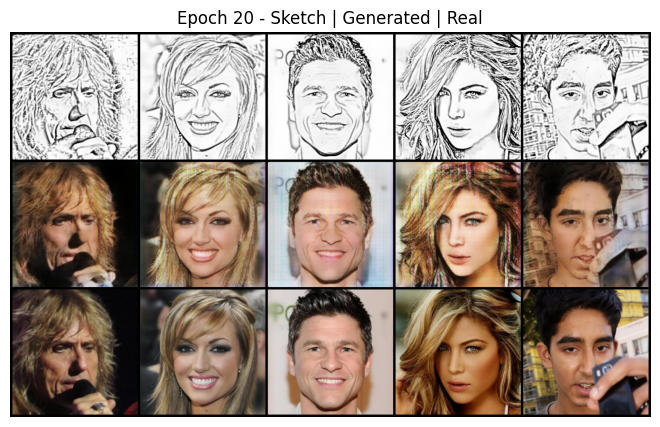

Training: 100%|██████████| 282/282 [06:15<00:00,  1.33s/it]


Epoch [21/50]  D Loss: 0.1182  G Loss: 20.7357


Training: 100%|██████████| 282/282 [06:13<00:00,  1.32s/it]


Epoch [22/50]  D Loss: 0.0346  G Loss: 18.9578


Training: 100%|██████████| 282/282 [06:13<00:00,  1.32s/it]


Epoch [23/50]  D Loss: 0.0340  G Loss: 24.2568


Training: 100%|██████████| 282/282 [06:13<00:00,  1.32s/it]


Epoch [24/50]  D Loss: 0.5792  G Loss: 15.0949


Training: 100%|██████████| 282/282 [06:14<00:00,  1.33s/it]


Epoch [25/50]  D Loss: 0.0703  G Loss: 22.0296
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:52<00:00,  1.65s/it]



📊 Evaluation Results
🔹 PSNR:               16.13
🔹 SSIM:               0.6921
🔹 LPIPS:              0.2535
🔹 FID:                132.12
🔹 Disc Confidence:    -3.3957


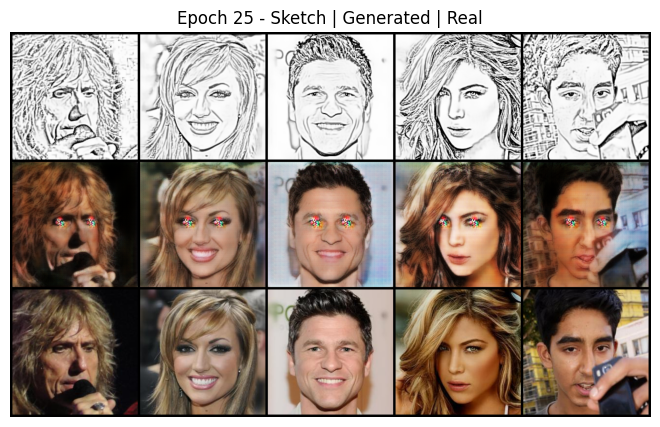

Training: 100%|██████████| 282/282 [06:13<00:00,  1.33s/it]


Epoch [26/50]  D Loss: 0.0132  G Loss: 21.1007


Training: 100%|██████████| 282/282 [06:12<00:00,  1.32s/it]


Epoch [27/50]  D Loss: 0.0548  G Loss: 18.4038


Training: 100%|██████████| 282/282 [06:12<00:00,  1.32s/it]


Epoch [28/50]  D Loss: 0.3831  G Loss: 12.9207


Training: 100%|██████████| 282/282 [06:11<00:00,  1.32s/it]


Epoch [29/50]  D Loss: 0.7289  G Loss: 19.7260


Training: 100%|██████████| 282/282 [06:09<00:00,  1.31s/it]


Epoch [30/50]  D Loss: 0.0246  G Loss: 16.8920
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:52<00:00,  1.64s/it]



📊 Evaluation Results
🔹 PSNR:               16.49
🔹 SSIM:               0.7027
🔹 LPIPS:              0.2179
🔹 FID:                157.18
🔹 Disc Confidence:    -2.3805


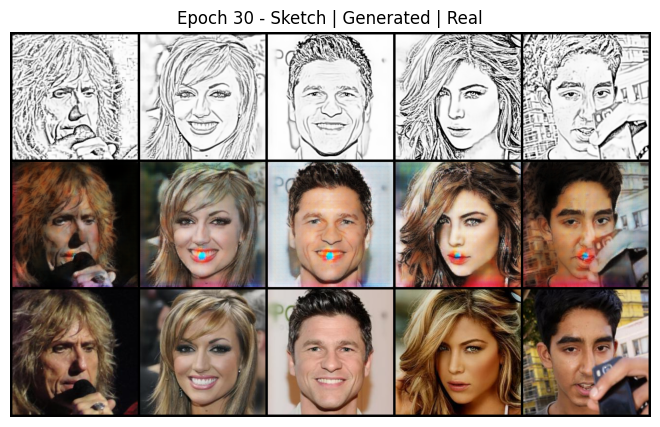

Training: 100%|██████████| 282/282 [06:11<00:00,  1.32s/it]


Epoch [31/50]  D Loss: 0.0337  G Loss: 19.7774


Training: 100%|██████████| 282/282 [06:09<00:00,  1.31s/it]


Epoch [32/50]  D Loss: 0.0039  G Loss: 19.9895


Training: 100%|██████████| 282/282 [06:09<00:00,  1.31s/it]


Epoch [33/50]  D Loss: 0.0589  G Loss: 15.3125


Training: 100%|██████████| 282/282 [06:10<00:00,  1.31s/it]


Epoch [34/50]  D Loss: 0.0029  G Loss: 19.0165


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [35/50]  D Loss: 0.0020  G Loss: 21.2454
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:52<00:00,  1.63s/it]



📊 Evaluation Results
🔹 PSNR:               16.50
🔹 SSIM:               0.6392
🔹 LPIPS:              0.2149
🔹 FID:                41.11
🔹 Disc Confidence:    -5.9808


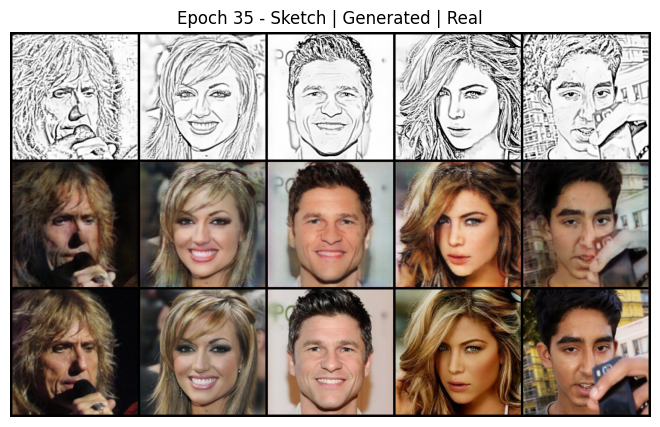

Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [36/50]  D Loss: 0.3912  G Loss: 11.7443


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [37/50]  D Loss: 0.0311  G Loss: 19.9321


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [38/50]  D Loss: 0.0071  G Loss: 20.7921


Training: 100%|██████████| 282/282 [06:07<00:00,  1.30s/it]


Epoch [39/50]  D Loss: 0.0805  G Loss: 17.6980


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [40/50]  D Loss: 0.1066  G Loss: 14.2419
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:52<00:00,  1.63s/it]



📊 Evaluation Results
🔹 PSNR:               16.85
🔹 SSIM:               0.7291
🔹 LPIPS:              0.1775
🔹 FID:                39.72
🔹 Disc Confidence:    -1.3398


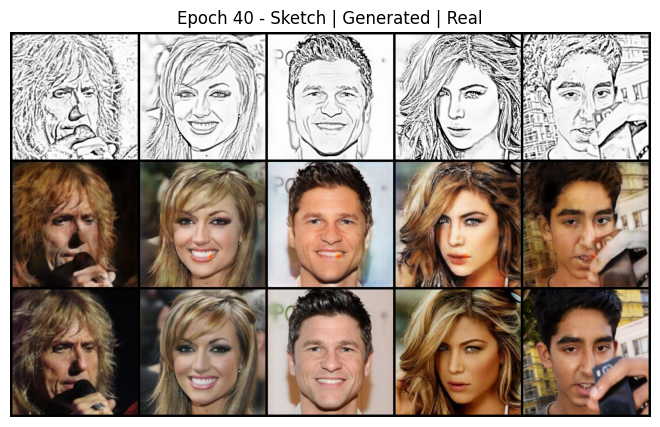

Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [41/50]  D Loss: 0.0925  G Loss: 16.5145


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [42/50]  D Loss: 0.0063  G Loss: 20.1814


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [43/50]  D Loss: 0.0129  G Loss: 17.8189


Training: 100%|██████████| 282/282 [06:09<00:00,  1.31s/it]


Epoch [44/50]  D Loss: 0.9053  G Loss: 11.2055


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [45/50]  D Loss: 0.0017  G Loss: 18.8687
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:52<00:00,  1.64s/it]



📊 Evaluation Results
🔹 PSNR:               16.40
🔹 SSIM:               0.6938
🔹 LPIPS:              0.2019
🔹 FID:                54.04
🔹 Disc Confidence:    -3.0463


Training: 100%|██████████| 282/282 [06:09<00:00,  1.31s/it]


Epoch [46/50]  D Loss: 0.0453  G Loss: 15.3375


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [47/50]  D Loss: 0.2495  G Loss: 11.7753


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [48/50]  D Loss: 0.1160  G Loss: 16.3637


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [49/50]  D Loss: 0.0091  G Loss: 16.4834


Training: 100%|██████████| 282/282 [06:08<00:00,  1.31s/it]


Epoch [50/50]  D Loss: 0.0110  G Loss: 19.1964
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:52<00:00,  1.65s/it]



📊 Evaluation Results
🔹 PSNR:               16.39
🔹 SSIM:               0.6983
🔹 LPIPS:              0.2099
🔹 FID:                43.29
🔹 Disc Confidence:    -2.5096


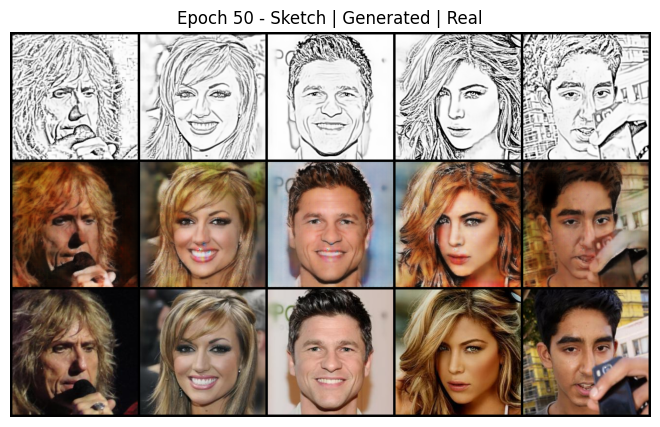

In [13]:
def save_sample(sketches, real_images, fake_images, epoch):
    sketches = denormalize(sketches)  # make sketches 3-channel
    real_images = denormalize(real_images)
    fake_images = denormalize(fake_images)

    # Interleave them: sketch, fake, real
    combined = torch.cat([sketches, fake_images, real_images], dim=0)
    grid = vutils.make_grid(combined, nrow=5, padding=5)

    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Epoch {epoch} - Sketch | Generated | Real")
    plt.axis('off')
    plt.show()


for epoch in range(1, EPOCHS + 1):
    G.train()
    D.train()
    for batch in tqdm(train_loader, desc="Training"):
        sketches, real_images = batch
        sketches = sketches.to(DEVICE)
        real_images = real_images.to(DEVICE)

        #######################
        # Train Discriminator #
        #######################
        fake_images = G(sketches)

        D_real = D(sketches, real_images)
        D_fake = D(sketches, fake_images.detach())

        real_labels = torch.ones_like(D_real)
        fake_labels = torch.zeros_like(D_fake)

        D_loss_real = bce_loss(D_real, real_labels)
        D_loss_fake = bce_loss(D_fake, fake_labels)
        D_loss = (D_loss_real + D_loss_fake) * 0.5

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        ##################
        # Train Generator#
        ##################
        D_output_fake = D(sketches, fake_images)
        G_adv_loss = bce_loss(D_output_fake, real_labels)
        G_l1_loss = l1_loss(fake_images, real_images)
        
        # Total Generator Loss
        G_loss = G_adv_loss + LAMBDA_L1 * G_l1_loss

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()
    
    print(f"Epoch [{epoch}/{EPOCHS}]  D Loss: {D_loss.item():.4f}  G Loss: {G_loss.item():.4f}")
    scheduler_G.step()
    scheduler_D.step()
    save_epoch_samples(G, fixed_sketches, epoch)
    # Save sample outputs
    if epoch % SAVE_SAMPLE_EVERY == 0:
        torch.save(G.state_dict(), f"pix2pix_generator_epoch{epoch}.pth")
        G.eval()
        metrics = evaluate_sketch2image(G, D, val_loader)  # or a small validation dataloader
        metrics["Epoch"] = epoch
        eval_history.append(metrics)
        pd.DataFrame(eval_history).to_csv("eval_metrics.csv", index=False)
        with torch.no_grad():
            sketches, real_images = next(iter(val_loader))
            sketches = sketches[:5].to(DEVICE)
            real_images = real_images[:5].to(DEVICE)
            fake_images = G(sketches)
            save_sample(sketches, real_images, fake_images, epoch)


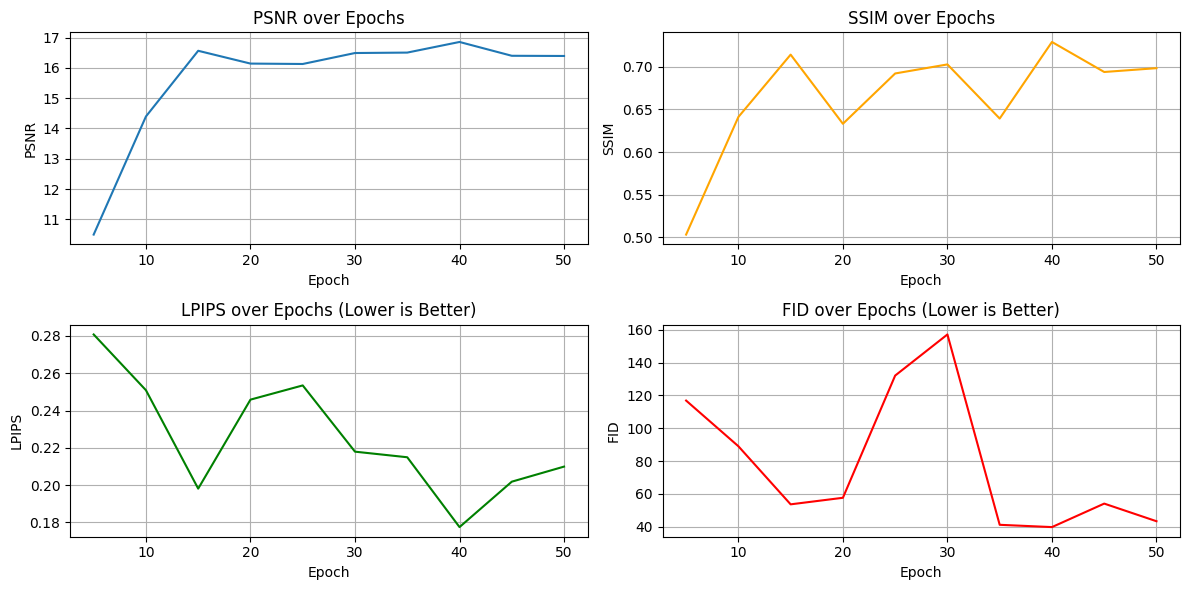

In [14]:
df = pd.read_csv("eval_metrics.csv")

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(df["Epoch"], df["PSNR"], label="PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.title("PSNR over Epochs")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(df["Epoch"], df["SSIM"], label="SSIM", color="orange")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM over Epochs")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(df["Epoch"], df["LPIPS"], label="LPIPS", color="green")
plt.xlabel("Epoch")
plt.ylabel("LPIPS")
plt.title("LPIPS over Epochs (Lower is Better)")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(df["Epoch"], df["FID"], label="FID", color="red")
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("FID over Epochs (Lower is Better)")
plt.grid()

plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()

In [15]:
def create_training_gif(save_dir="training_progress", gif_name="training_progress.gif", fps=10):
    images = []
    for epoch in sorted(os.listdir(save_dir)):
        if epoch.endswith(".png"):
            images.append(imageio.imread(os.path.join(save_dir, epoch)))
    imageio.mimsave(gif_name, images, fps=fps)
    
create_training_gif()

In [16]:
# Save Generator model
torch.save(G.state_dict(), "pix2pix_generator.pth")

In [17]:
evaluation_metrics= evaluate_sketch2image(G,D,val_loader)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|██████████| 32/32 [00:52<00:00,  1.64s/it]



📊 Evaluation Results
🔹 PSNR:               16.39
🔹 SSIM:               0.6983
🔹 LPIPS:              0.2099
🔹 FID:                43.29
🔹 Disc Confidence:    -2.5096


In [18]:
# Get a single batch from the loader
sketches, real_images = next(iter(val_loader))

# Select one sample
sketch = sketches[0]           # Shape: (1, H, W)
real_image = real_images[0]    # Optional: For comparison


G = UNetGenerator().to(DEVICE)
G.load_state_dict(torch.load("pix2pix_generator.pth",weights_only=True))
G.eval()

with torch.no_grad():
    sketch_input = sketch.unsqueeze(0).to(DEVICE)  # Add batch dimension → (1, 1, H, W)
    fake_image = G(sketch_input)    

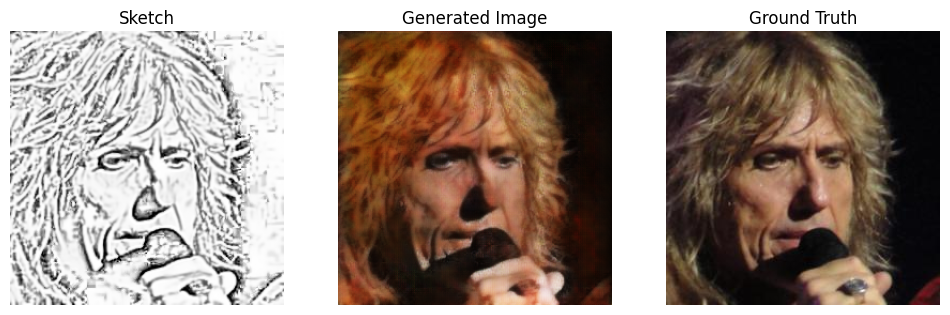

In [19]:
def denormalize(t):
    return t * 0.5 + 0.5

import matplotlib.pyplot as plt

sketch_np = denormalize(sketch).squeeze().permute(1, 2, 0).cpu().numpy()
fake_np = denormalize(fake_image.squeeze()).permute(1, 2, 0).cpu().numpy()
real_np = denormalize(real_image).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Sketch")
plt.imshow(sketch_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Generated Image")
plt.imshow(fake_np)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(real_np)
plt.axis('off')

plt.show()
